## Making the study area

To employ the internal Rossby radius of deformation to limit the study area, I have decided to try the following:
- Make a polygon around the wind park by finding minimum and maximum of lon/lat in the coordinates.
- Then add X times the Rossby radius in all directions. Choice of X depends on what it looks like. I want to make X big enough such that the wind wake is within.
- I will choose the mean Rossby radius of June to be the value 'to add on'. This is because I would like to make sure that the largest eddies are also seen. 
- Below I'm testing this approach on Sørvest-F and Nordvest-C to see if the method works and looks reasonable.

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import numpy as np
import xarray as xr
import cartopy 
from datetime import datetime, timedelta
import pandas as pd
from Rossby_deformation.get_turbine_coords import get_turbine_coords
from netCDF4 import Dataset
from roppy import SGrid
import xroms
from cartopy import config
from glob import glob
from Rossby_deformation.funcs import *

%load_ext autoreload
%autoreload 2

In [2]:
# Opening a file to retrieve the grid
fid = Dataset('/lustre/storeB/project/nwp/havvind/hav/results/reference/REF-02/norkyst_avg_0001.nc')
grid = SGrid(fid)
del fid

In [3]:
# Opening the turbine coordinates as a xArray DataSet
sorvest_F = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Sorvest_F.txt')

In [4]:
nordvest_C = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Nordvest_C.txt')

In [9]:
# Extracting paths to files containing the computed Rossby deformation radius
# Note: I'm using the reference datasets and not the experiments
# Rossby deformation radius computed from the experiment datasets are found in output_bdr/EXP

filefolder = glob('/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/REF')

months = {
"02": 27,  # February
"03": 31,  # March
"04": 30,  # April
"05": 31,  # May
"06": 30   # June
}

files=[]  # empty list to store paths in

# building paths to contain each daily file and named thereafter
for month, days in months.items():
    for day in range(1, days + 1): 
        day_str = f"{day:04}"
        file_path = f'/REF_{month}_norkyst_avg_{day_str}_brr.nc'
        files.append(filefolder[0]+file_path)

In [5]:
# Longitudes and latitudes of the grid
lon = grid.lon_rho
lat = grid.lat_rho

In [ ]:
# Square around wind park
min_lon_SV = np.min(sorvest_F.coordinates[:,0])
min_lat_SV = np.min(sorvest_F.coordinates[:,1])
max_lon_SV = np.max(sorvest_F.coordinates[:,0])
max_lat_SV = np.max(sorvest_F.coordinates[:,1])

area_lon_SV = [min_lon_SV, max_lon_SV]
area_lat_SV = [min_lat_SV, max_lat_SV]

In [8]:
min_lon_NV = np.min(nordvest_C.coordinates[:,0])
min_lat_NV = np.min(nordvest_C.coordinates[:,1])
max_lon_NV = np.max(nordvest_C.coordinates[:,0])
max_lat_NV = np.max(nordvest_C.coordinates[:,1])

area_lon_NV = [min_lon_NV, max_lon_NV]
area_lat_NV = [min_lat_NV, max_lat_NV]

In [10]:
R1_mon_mean_SV = monthly_mean_area(files, grid, area_lon_SV, area_lat_SV)
R1_mon_mean_NV = monthly_mean_area(files, grid, area_lon_NV, area_lat_NV)

In [11]:
ds_SV = make_study_area(files, grid, area_lon_SV, area_lat_SV, R1_mon_mean_SV[-1])

In [12]:
ds_NV = make_study_area(files, grid, area_lon_NV, area_lat_NV, R1_mon_mean_NV[-1])

In [17]:
ds_monthly = monthly_mean(files)

In [25]:
ds_SV_mon = ds_SV.gamma_r.resample(ocean_time='1M').mean(dim='ocean_time')

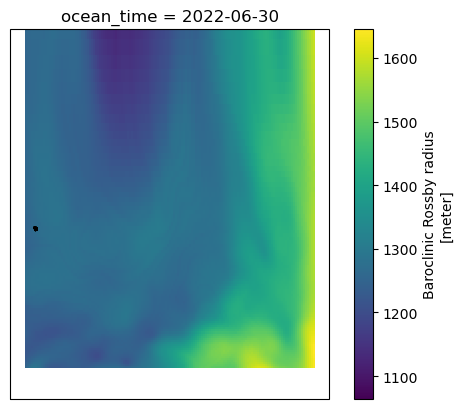

In [32]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.Mercator()})
ds_SV_mon.isel(ocean_time=-1).plot(ax = ax, transform=ccrs.PlateCarree())
for i in range(len(sorvest_F.coordinates)):
        ax.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=1)

In [30]:
ds_NV_mon = ds_NV.gamma_r.resample(ocean_time='1M').mean(dim='ocean_time')

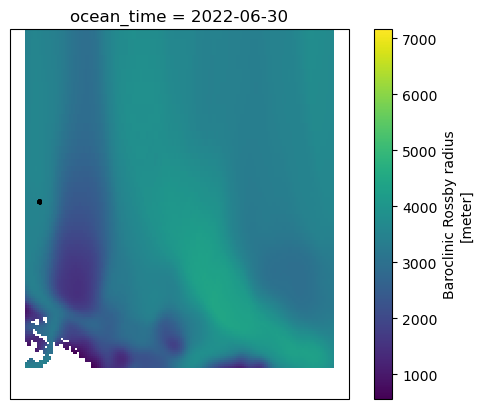

In [35]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.Mercator()})
ds_NV_mon.isel(ocean_time=-1).plot(ax = ax, transform=ccrs.PlateCarree())
for i in range(len(nordvest_C.coordinates)):
        ax.plot(nordvest_C.coordinates[i][0],nordvest_C.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=1)

In [46]:
ds_SV

<xarray.Dataset>
Dimensions:     (ocean_time: 149, eta_rho: 139, xi_rho: 145)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2022-02-02T12:00:00 ... 2022-06-3...
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    bvf         (ocean_time, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 139, 145), meta=np.ndarray>
    gamma_r     (ocean_time, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 139, 145), meta=np.ndarray>